In [1]:
!python -V

Python 3.9.25


In [2]:
import pandas as pd

In [5]:
pd.__version__

'2.3.3'

In [3]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment5")

2025/12/23 15:19:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/23 15:19:30 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops_zoomcamp/mlruns/5', creation_time=1766484629651, experiment_id='5', last_update_time=1766484629651, lifecycle_stage='active', name='nyc-taxi-experiment5', tags={}>

In [6]:
#!pip install pyarrow

In [4]:
# read the url of a Yellow NYC taxi ride parquet file from Jan 2023:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
import sklearn

#### Q1. Downloading the data -

Read the data for January. How many columns are there?

In [9]:
# Read the data for January. How many columns are there?
columns_in_jan = df.columns
print(len(columns_in_jan))

19


Ans: 19

#### Q2. Computing duration

In [12]:
type(df['tpep_dropoff_datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
(df['tpep_dropoff_datetime'][0] - df['tpep_pickup_datetime'][0])

Timedelta('0 days 00:08:26')

In [6]:
# computing the duration of a ride in minutes:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime) / pd.Timedelta(minutes=1)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [15]:
df.duration.shape

(3066766,)

In [16]:
df.shape

(3066766, 20)

What's the standard deviation of the trips duration in January?

In [17]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

df.duration.describe()

count   3066766.00
mean         15.67
std          42.59
min         -29.20
25%           7.12
50%          11.52
75%          18.30
max       10029.18
Name: duration, dtype: float64

Ans: 42..59

#### Q3. Dropping outliers

In [18]:
print(df.duration.min(), df.duration.max())

-29.2 10029.183333333332


<Axes: xlabel='duration'>

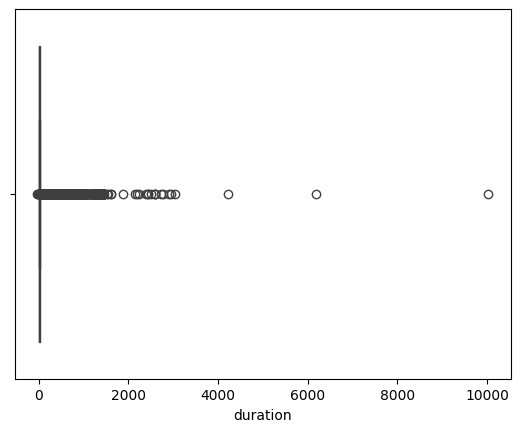

In [19]:
# check the distribution of the duration variable:
import seaborn as sns

# method 1 - boxplot:
sns.boxplot(x=df['duration'])

<Axes: ylabel='duration'>

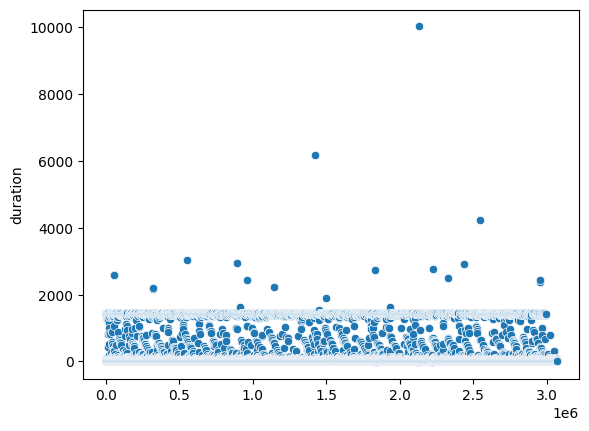

In [20]:
# method 2 - 
sns.scatterplot(x=range(len(df['duration'])), y=df['duration'])

In [21]:
# method 3 - Z-score:
# calculates how many standard deviations a data point is from the mean. 
# Data points with a Z-score greater than 3 or less than -3 are considered outliers.
import numpy as np
from scipy import stats

z = np.abs(stats.zscore(df['duration']))
# print("Z-Score Values:\n", z)

outliers = df.duration[z > 3]
print("Outliers:\n", outliers)

Outliers:
 383       1421.10
533       1376.77
546       1406.93
1244      1437.00
2510      1415.67
            ...  
2997392    173.43
3010767    226.00
3019950    167.33
3020900    785.70
3049731    319.40
Name: duration, Length: 3175, dtype: float64


In [22]:
# method 4 - IQR:
# identifies outliers by measuring the spread between the first quartile (Q1) and third quartile (Q3). Any data point below 
# Q1 - 1.5 *IQR i.e., lower bound or above Q3 + 1.5 * IQR i.e., upper bound is considered an outlier.
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['duration'] < lower_bound) | (df['duration'] > upper_bound)]
print("Outliers:\n")
outliers

Outliers:



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
48,2,2023-01-01 00:41:41,2023-01-01 01:19:32,1.00,11.11,1.00,N,132,61,1,47.80,1.00,0.50,10.31,0.00,1.00,61.86,0.00,1.25,37.85
54,1,2023-01-01 00:46:17,2023-01-01 01:25:30,1.00,3.30,1.00,N,43,125,1,30.30,3.50,0.50,2.00,0.00,1.00,37.30,2.50,0.00,39.22
59,2,2023-01-01 00:22:39,2023-01-01 01:30:45,1.00,16.02,1.00,N,132,265,2,61.10,1.00,0.50,0.00,0.00,1.00,64.85,0.00,1.25,68.10
64,1,2023-01-01 00:18:29,2023-01-01 00:55:20,1.00,11.30,1.00,N,163,225,1,48.50,3.50,0.50,10.70,0.00,1.00,64.20,2.50,0.00,36.85
89,2,2023-01-01 00:25:14,2023-01-01 01:00:29,3.00,11.19,1.00,N,239,133,1,49.20,1.00,0.50,12.15,6.55,1.00,72.90,2.50,0.00,35.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066473,2,2023-01-31 21:23:28,2023-01-31 21:59:32,NaN,8.75,NaN,None,161,62,0,36.19,0.00,0.50,4.02,0.00,1.00,44.21,NaN,NaN,36.07
3066558,2,2023-01-31 21:37:00,2023-01-31 22:19:00,NaN,9.51,NaN,None,161,188,0,39.35,0.00,0.50,0.00,0.00,1.00,43.35,NaN,NaN,42.00
3066598,2,2023-01-31 21:30:08,2023-01-31 22:06:39,NaN,14.62,NaN,None,164,123,0,49.30,0.00,0.50,0.00,6.55,1.00,59.85,NaN,NaN,36.52
3066701,2,2023-01-31 22:03:26,2023-01-31 22:46:13,NaN,11.20,NaN,None,100,188,0,40.47,0.00,0.50,8.89,0.00,1.00,53.36,NaN,NaN,42.78


In [7]:
import pandas as pd
import numpy as np

# capping outliers:
lower_limit = 1
upper_limit = 60

# Store the original number of records
original_row_count = df.duration.shape[0] # or use df.shape[0]

# 2. Define a method to remove outliers (using IQR for example)


# Create a new DataFrame without outliers
df_cleaned = df[(df['duration'] >= lower_limit) & (df['duration'] <= upper_limit)]

# 3. Store the number of records after removing outliers
cleaned_row_count = len(df_cleaned)

# 4. Calculate the fraction of remaining records
fraction_remaining = cleaned_row_count / original_row_count

# Print the result
print(f"Original number of records: {original_row_count}")
print(f"Number of records after removing outliers: {cleaned_row_count}")
print(f"Fraction of records left: {fraction_remaining:.2f} (or {fraction_remaining*100:.2f}%)")

Original number of records: 3066766
Number of records after removing outliers: 3009173
Fraction of records left: 0.98 (or 98.12%)


What fraction of the records left after you dropped the outliers?

Ans: 98%

#### Q4. One-hot encoding

apply one-hot encoding to the pickup and dropoff location IDs:
* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
* Fit a dictionary vectorizer
* Get a feature matrix from it

In [ ]:
df_cleaned.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.00,0.97,1.00,N,161,141,2,9.30,1.00,0.50,0.00,0.00,1.00,14.30,2.50,0.00,8.43
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.00,1.10,1.00,N,43,237,1,7.90,1.00,0.50,4.00,0.00,1.00,16.90,2.50,0.00,6.32
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.00,2.51,1.00,N,48,238,1,14.90,1.00,0.50,15.00,0.00,1.00,34.90,2.50,0.00,12.75
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.00,1.90,1.00,N,138,7,1,12.10,7.25,0.50,0.00,0.00,1.00,20.85,0.00,1.25,9.62
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.00,1.43,1.00,N,107,79,1,11.40,1.00,0.50,3.28,0.00,1.00,19.68,2.50,0.00,10.83


: 

In [8]:
from sklearn.feature_extraction import DictVectorizer

df_cleaned['PULocationID'] = df_cleaned['PULocationID'].apply(str)
df_cleaned['DOLocationID'] = df_cleaned['DOLocationID'].apply(str)

categorical = ["PULocationID", "DOLocationID"]
numerical = []
target = "duration"
def train_val_data(df):
    train_dicts = df[categorical + numerical].to_dict(orient="records")
    
    dv = DictVectorizer()
    
    x_train = dv.fit_transform(train_dicts)
    print("Dimensionality of feature matrix:", x_train.shape)

    y_train = df[target].values
    return x_train, y_train

x_train, y_train = train_val_data(df= df_cleaned)

/tmp/ipykernel_2316/4043461369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['PULocationID'] = df_cleaned['PULocationID'].apply(str)
/tmp/ipykernel_2316/4043461369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['DOLocationID'] = df_cleaned['DOLocationID'].apply(str)


Dimensionality of feature matrix: (3009173, 515)


What's the dimensionality of this matrix (number of columns)?


Ans: 515

#### Q5. Training a model

* Train a plain linear regression model with default parameters, where duration is the response variable
* Calculate the RMSE of the model on the training data

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the model
lr = LinearRegression()
y = df_cleaned.duration.values

# Train the model
lr.fit(x_train, y_train)

# calculate RMSE on training data 
y_pred_train = lr.predict(x_train)
print("RMSE on train: ", np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)))

RMSE on train:  7.649261934850555


What's the RMSE on train?

Ans. 7.64

In [10]:
import pickle 

dv = DictVectorizer()

In [19]:
with open('02-experiment_tracking/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

#### Q6. Evaluating the model

apply this model to the validation dataset (February 2023) 

In [11]:
# similar to Jan 2023 yellow taxi ride data parquet above, here we read the Feb 2023 parquet:
# read the url of a Yellow NYC taxi ride parquet file from Feb 2023:
df2 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')
df2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


In [12]:
# computing the duration of a ride in minutes:
df2['duration'] = (df2.tpep_dropoff_datetime - df2.tpep_pickup_datetime) / pd.Timedelta(minutes=1)

In [13]:
import pandas as pd
import numpy as np

# capping outliers:
lower_limit = 1
upper_limit = 60

# Define a method to remove outliers (using IQR for example)
# Create a new DataFrame without outliers
df2_cleaned = df2[(df2['duration'] >= lower_limit) & (df2['duration'] <= upper_limit)]
df2_cleaned.shape

(2855951, 20)

In [14]:
categorical = ["PULocationID", "DOLocationID"]
numerical = []
target = "duration"
def train_val_data(train_df, val_df):
    train_dicts = train_df[categorical + numerical].to_dict(orient="records")
    val_dicts = val_df[categorical+numerical].to_dict(orient="records")
    
    dv = DictVectorizer()
    
    x_train = dv.fit_transform(train_dicts)
    # print("Dimensionality of feature matrix:", x_train.shape)
    x_val = dv.transform(val_dicts)

    y_train = train_df[target].values
    y_val = val_df[target].values
    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = train_val_data(train_df=df_cleaned, val_df=df2_cleaned)

In [15]:
# calculate RMSE on training data 
y_pred_val = lr.predict(x_val)
print("RMSE on val: ", np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred_val)))

RMSE on val:  13.322405810859994


What's the RMSE on validation?

Ans: 13.31

In [35]:
from sklearn import linear_model

with mlflow.start_run():
  mlflow.set_tag("developer", "ML1")
  
  mlflow.log_param("train-data-path", "./data/yellow_tripdata_2023-01.parquet")
  mlflow.log_param("valid-data-path", "./data/yellow_tripdata_2023-02.parquet")

  alpha = 0.01
  mlflow.log_param("alpha", alpha)

  lr = linear_model.Lasso(alpha)
  lr.fit(x_train, y_train)

  y_pred = lr.predict(x_val)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  mlflow.log_metric("rmse", rmse)


Hyperoptimize model parameters using hyperopt

In [16]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [17]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_val, label=y_val)

In [ ]:
# def objective(params):
#     with mlflow.start_run():
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=100,
#             evals=[(valid, "validation")],
#             early_stopping_rounds=30
#         )

#         y_pred = booster.predict(valid)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         mlflow.log_metric("rmse", rmse)

#     return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100,1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed':42
#     }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:19:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.13580                          
[1]	validation-rmse:10.08223                          
[2]	validation-rmse:10.11055                          
[3]	validation-rmse:10.13032                          
[4]	validation-rmse:10.14912                          
[5]	validation-rmse:10.07311                          
[6]	validation-rmse:10.07556                          
[7]	validation-rmse:10.07561                          
[8]	validation-rmse:10.07707                          
[9]	validation-rmse:10.07289                          
[10]	validation-rmse:10.07308                         
[11]	validation-rmse:10.07370                         
[12]	validation-rmse:10.07348                         
[13]	validation-rmse:10.07413                         
[14]	validation-rmse:10.07205                         
[15]	validation-rmse:10.07223                         
[16]	validation-rmse:10.07257                         
[17]	validation-rmse:10.07134                         
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.28343                                                    
[1]	validation-rmse:10.11218                                                    
[2]	validation-rmse:10.12912                                                    
[3]	validation-rmse:10.13191                                                    
[4]	validation-rmse:10.12565                                                    
[5]	validation-rmse:10.12764                                                    
[6]	validation-rmse:10.13022                                                    
[7]	validation-rmse:10.13082                                                    
[8]	validation-rmse:10.13263                                                    
[9]	validation-rmse:10.13203                                                    
[10]	validation-rmse:10.13272                                                   
[11]	validation-rmse:10.13384                                                   
[12]	validation-rmse:10.1339

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.07652                                                    
[1]	validation-rmse:10.08842                                                    
[2]	validation-rmse:10.10437                                                    
[3]	validation-rmse:10.11898                                                    
[4]	validation-rmse:10.13752                                                    
[5]	validation-rmse:10.13973                                                    
[6]	validation-rmse:10.15641                                                    
[7]	validation-rmse:10.17123                                                    
[8]	validation-rmse:10.16790                                                    
[9]	validation-rmse:10.18155                                                    
[10]	validation-rmse:10.19338                                                   
[11]	validation-rmse:10.20529                                                   
[12]	validation-rmse:10.2172

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.23047                                                    
[1]	validation-rmse:10.11075                                                    
[2]	validation-rmse:10.13522                                                    
[3]	validation-rmse:10.14816                                                    
[4]	validation-rmse:10.14708                                                    
[5]	validation-rmse:10.14592                                                    
[6]	validation-rmse:10.13967                                                    
[7]	validation-rmse:10.14135                                                    
[8]	validation-rmse:10.14116                                                    
[9]	validation-rmse:10.13974                                                    
[10]	validation-rmse:10.14113                                                   
[11]	validation-rmse:10.13593                                                   
[12]	validation-rmse:10.1355

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.38101                                                    
[1]	validation-rmse:10.29000                                                    
[2]	validation-rmse:10.27727                                                    
[3]	validation-rmse:10.29159                                                    
[4]	validation-rmse:10.29401                                                    
[5]	validation-rmse:10.30231                                                    
[6]	validation-rmse:10.29853                                                    
[7]	validation-rmse:10.29735                                                    
[8]	validation-rmse:10.29810                                                    
[9]	validation-rmse:10.29866                                                    
[10]	validation-rmse:10.29606                                                   
[11]	validation-rmse:10.29559                                                   
[12]	validation-rmse:10.2956

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



 10%|█         | 5/50 [02:42<24:26, 32.59s/trial, best loss: 10.077643369296503]


KeyboardInterrupt: 

Model Management using MLFlow -

In [ ]:
# Method 1 - by saving model to the artifact path in MLFlow:
from sklearn import linear_model

with mlflow.start_run():
  mlflow.set_tag("developer", "ML1")
  
  mlflow.log_param("train-data-path", "./data/yellow_tripdata_2023-01.parquet")
  mlflow.log_param("valid-data-path", "./data/yellow_tripdata_2023-02.parquet")

  alpha = 0.01
  mlflow.log_param("alpha", alpha)

  lr = linear_model.Lasso(alpha)
  lr.fit(x_train, y_train)

  y_pred = lr.predict(x_val)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  mlflow.log_metric("rmse", rmse)

  # saving the model as an artifact:
  mlflow.log_artifact(local_path="02-experiment_tracking/models/lin_reg.bin", artifact_path="models_pickle")


In [18]:
# Method 2 - 
with mlflow.start_run():

    best_params={
        'learning_rate': 0.095853553,
        'max_depth': 3,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.01806024,
        'reg_lambda': 0.01165873,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=10,
        evals=[(valid, "validation")],
        early_stopping_rounds=3
    )

    y_pred = booster.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    # logging the model:
    # Add input example for signature inference 
    feature_names = [f"f{i}" for i in range(x_train.shape[1])] 
    input_example = pd.DataFrame(x_train[:1].toarray(), columns=feature_names)

    # save the model as a pickle:
    with open("02-experiment_tracking/models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    # logging the pre-processor as an artifact:
    mlflow.log_artifact("02-experiment_tracking/models/preprocessor.b", artifact_path='preprocessor')

    mlflow.xgboost.log_model(booster, name='models_mlflow', input_example=input_example)

[0]	validation-rmse:10.07266
[1]	validation-rmse:10.07905
[2]	validation-rmse:10.08638


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Loading models from Flavours saved as artifacts in MLFlow - 

In [19]:
logged_model = 'runs:/3ac5f6780b99492191416088479b7af2/models_mlflow'

# load model as a PyFuncModel:
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [20]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: /workspaces/mlops_zoomcamp/mlruns/5/models/m-0d9384d1d8a0460b87645e5eaa6744f0/artifacts
  flavor: mlflow.xgboost
  run_id: 3ac5f6780b99492191416088479b7af2

In [21]:
# loading the model as an XGBoost model:
xgboost_model = mlflow.xgboost.load_model(logged_model)


In [22]:
# seeing the xgboost object:
xgboost_model

Making predictions from loaded model objects - 

In [23]:
# making predictions on validation set using xgboost model object:
y_pred = xgboost_model.predict(valid)

In [24]:
y_pred[:10]

array([13.68999, 13.68999, 13.68999, 13.68999, 13.68999, 13.68999,
       13.68999, 13.68999, 13.68999, 13.68999], dtype=float32)

Using Python API for MLFLow to search or create experiments - 

In [25]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [27]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops_zoomcamp/mlruns/5', creation_time=1766484629651, experiment_id='5', last_update_time=1766484629651, lifecycle_stage='active', name='nyc-taxi-experiment5', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops_zoomcamp/mlruns/4', creation_time=1766422020171, experiment_id='4', last_update_time=1766422020171, lifecycle_stage='active', name='nyc-taxi-experiment4', tags={}>]

In [28]:
client.create_experiment(name='my-cool-experiment')

'6'

In [33]:
# what are the best runs for a given model:
from mlflow.entities import ViewType
runs = client.search_runs(
    experiment_ids='1',
    filter_string='metrics.rmse > 10.1',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [35]:
runs

[]

In [38]:
model_name = 'nyc_taxi_regressor'

latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 2, stage: None


/tmp/ipykernel_2316/1240631534.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)
